In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import pandas as pd
import numpy as np
import imp
import matplotlib.pyplot as plt
import xgboost
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns
%matplotlib inline
from HelperClass.DataProcessing import *

In [3]:
trainDataFile = 'Data/train.csv'
testDataFile = 'Data/test.csv'
dataTypes = {
    'PassengerId' : 'int64',
    'Survived' : 'int64',
    'Pclass' : 'int64',
    'Name' : 'object',
    'Sex' : 'object',
    'Age' : 'float64',
    'SibSp' : 'int64',
    'Parch' : 'int64',
    'Ticket' : 'object',
    'Fare' : 'float64',
    'Cabin' : 'object',
    'Embarked' : 'object'
}
sep = ','
target = 'Survived'
randomSeed = 83213
testRatio = 0.20
numCores = 10

In [4]:
dataProc = DataProcessing(trainDataFile, dataTypes, sep)
dataProc.ReadFile()
dataProc.AllData = dataProc.AllData[~dataProc.AllData.Embarked.isnull()]

submitDataProc = DataProcessing(testDataFile, dataTypes, sep)
submitDataProc.ReadFile()
submitDataProc.AllData = submitDataProc.AllData[~submitDataProc.AllData.Embarked.isnull()]

Findings
1. Age makes difference, F_onewayResult(statistic=4.271194933815904, pvalue=0.03912465401348333)
2. Fare makes difference, F_onewayResult(statistic=63.03076422804448, pvalue=6.120189341921873e-15)
3. PassengerId doesn't make difference, F_onewayResult(statistic=0.022284812266068058, pvalue=0.8813657768798144)
4. Pclass makes difference, F_onewayResult(statistic=115.03127218827665, pvalue=2.5370473879805644e-25)
5. SibSp doesn't make difference, F_onewayResult(statistic=1.110572204113227, pvalue=0.29224392869817906)
6. Parch makes difference, F_onewayResult(statistic=5.963463836603541, pvalue=0.0147992453747224)

In [5]:
def PopulateFeatures(data):
    data.Cabin.fillna('NA', inplace=True)
    data['CabinType'] = data.Cabin.fillna('NA').str.get(0)
    return data

In [6]:
dataProc.AllData = PopulateFeatures(dataProc.AllData)
submitDataProc.AllData = PopulateFeatures(submitDataProc.AllData)

In [7]:
dataProc.AllData['CabinType_B_D_E'] = np.where(dataProc.AllData.CabinType.isin(['B', 'D', 'E']), 2, 1)
submitDataProc.AllData['CabinType_B_D_E'] = np.where(submitDataProc.AllData.CabinType.isin(['B', 'D', 'E']), 2, 1)

In [8]:
dataProc.AllData.Age.fillna(-999, inplace=True)
submitDataProc.AllData.Age.fillna(-999, inplace=True)

In [9]:
bins = [-10000, 0, 20, 60, 1000]
dataProc.AllData['AgeGroup'] = pd.cut(dataProc.AllData.Age, bins).astype(str)
submitDataProc.AllData['AgeGroup'] = pd.cut(submitDataProc.AllData.Age, bins).astype(str)

In [10]:
dataProc.AllData['GenderAgeGroup'] = dataProc.AllData.Sex + '_' + dataProc.AllData.AgeGroup
submitDataProc.AllData['GenderAgeGroup'] = submitDataProc.AllData.Sex + '_' + submitDataProc.AllData.AgeGroup

In [11]:
dataProc.AllData.groupby(['GenderAgeGroup']).agg({'Survived' : ['mean', 'count']}).sort_values(by=('Survived', 'mean'), 
                                                                                               ascending=False)

Survived      
                        mean count
GenderAgeGroup                    
female_(60, 1000]   1.000000     2
female_(20, 60]     0.777778   180
female_(0, 20]      0.688312    77
female_(-10000, 0]  0.679245    53
male_(0, 20]        0.284314   102
male_(20, 60]       0.186747   332
male_(-10000, 0]    0.129032   124
male_(60, 1000]     0.105263    19

In [12]:
genderAgeGroups = {
    'GenderAgeGroup' : {
        'female_(20, 60]' : 7, 
        'female_(60, 1000]' : 8,
        'female_(0, 20]' : 6, 
        'female_(-10000, 0]' : 5,
        'male_(0, 20]' : 4, 
        'male_(20, 60]' : 3, 
        'male_(-10000, 0]' : 2, 
        'male_(60, 1000]' : 1
    }
}

In [13]:
dataProc.AllData.replace(genderAgeGroups, inplace=True)
submitDataProc.AllData.replace(genderAgeGroups, inplace=True)

In [14]:
dataProc.AllData['Sex'] = np.where(dataProc.AllData['Sex'] == 'male', 1, 2)
submitDataProc.AllData['Sex'] = np.where(submitDataProc.AllData['Sex'] == 'male', 1, 2)

In [15]:
embarkedEncoding = {
    'Embarked' : {
       'S' : 1,
       'Q' : 1,
       'C' : 2
    }
}

In [16]:
dataProc.AllData.replace(embarkedEncoding, inplace=True)
submitDataProc.AllData.replace(embarkedEncoding, inplace=True)

In [17]:
numCols = ['Fare', 'Pclass', 'Parch', 'CabinType_B_D_E', 'GenderAgeGroup', 'Embarked', 'Sex']

ageFilledInData

dataProc.AllData['Ticket_Num_Ind'] = dataProc.AllData['Ticket'].str.isnumeric()

In [18]:
dataProc.PopulateFeatureColumns(numCols)
submitDataProc.PopulateFeatureColumns(numCols)

In [19]:
dataProc.PopulateFeatureAndLabel(target)
submitDataProc.X = submitDataProc.AllData[numCols]

In [20]:
dataProc.RandomSplitTrainTestData(testRatio, randomSeed, False)

In [21]:
averageFareThridClass = submitDataProc.AllData[(submitDataProc.AllData.Pclass == 3) & 
                                               (submitDataProc.AllData.CabinType == 'N')].Fare.mean()
submitDataProc.X.Fare.fillna(averageFareThridClass, inplace=True)

In [22]:
sortedCols = ['CabinType_B_D_E', 'Embarked', 'Fare', 'GenderAgeGroup', 'Parch', 'Pclass', 'Sex']

## NN model

In [24]:
dataProc.X_train.shape

(711, 15)

In [84]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(10, activation='relu', input_dim=7))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(dataProc.X_train.reindex(columns=sortedCols), dataProc.y_train, 
          validation_split=0.15,
          epochs=500, batch_size=50)

Train on 604 samples, validate on 107 samples
Epoch 1/500
604/604 [==============================] - 1s 2ms/step - loss: 1.4961 - acc: 0.6325 - val_loss: 1.1359 - val_acc: 0.6355
Epoch 2/500
604/604 [==============================] - 0s 113us/step - loss: 0.9773 - acc: 0.7020 - val_loss: 0.6847 - val_acc: 0.6916
Epoch 3/500
604/604 [==============================] - 0s 129us/step - loss: 0.6502 - acc: 0.6606 - val_loss: 0.6420 - val_acc: 0.6355
Epoch 4/500
604/604 [==============================] - 0s 113us/step - loss: 0.5865 - acc: 0.6871 - val_loss: 0.5647 - val_acc: 0.7477
Epoch 5/500
604/604 [==============================] - 0s 123us/step - loss: 0.5267 - acc: 0.7831 - val_loss: 0.5439 - val_acc: 0.7477
Epoch 6/500
604/604 [==============================] - 0s 109us/step - loss: 0.5097 - acc: 0.7732 - val_loss: 0.5456 - val_acc: 0.7103
Epoch 7/500
604/604 [==============================] - 0s 96us/step - loss: 0.5014 - acc: 0.7748 - val_loss: 0.5591 - val_acc: 0.6822
Epoch 8/500


604/604 [==============================] - 0s 93us/step - loss: 0.4587 - acc: 0.7732 - val_loss: 0.5434 - val_acc: 0.7477
Epoch 62/500
604/604 [==============================] - 0s 99us/step - loss: 0.4616 - acc: 0.7748 - val_loss: 0.5525 - val_acc: 0.7290
Epoch 63/500
604/604 [==============================] - 0s 88us/step - loss: 0.4623 - acc: 0.7781 - val_loss: 0.5519 - val_acc: 0.7477
Epoch 64/500
604/604 [==============================] - 0s 88us/step - loss: 0.4631 - acc: 0.7666 - val_loss: 0.5464 - val_acc: 0.7477
Epoch 65/500
604/604 [==============================] - 0s 86us/step - loss: 0.4723 - acc: 0.7765 - val_loss: 0.5508 - val_acc: 0.7383
Epoch 66/500
604/604 [==============================] - 0s 84us/step - loss: 0.4624 - acc: 0.7649 - val_loss: 0.5473 - val_acc: 0.7383
Epoch 67/500
604/604 [==============================] - 0s 84us/step - loss: 0.4578 - acc: 0.7732 - val_loss: 0.5405 - val_acc: 0.7477
Epoch 68/500
604/604 [==============================] - 0s 84us/step

604/604 [==============================] - 0s 101us/step - loss: 0.4517 - acc: 0.7748 - val_loss: 0.5553 - val_acc: 0.7290
Epoch 122/500
604/604 [==============================] - 0s 127us/step - loss: 0.4548 - acc: 0.7715 - val_loss: 0.5425 - val_acc: 0.7570
Epoch 123/500
604/604 [==============================] - 0s 89us/step - loss: 0.4605 - acc: 0.7815 - val_loss: 0.5559 - val_acc: 0.7290
Epoch 124/500
604/604 [==============================] - 0s 88us/step - loss: 0.4542 - acc: 0.7682 - val_loss: 0.5504 - val_acc: 0.7570
Epoch 125/500
604/604 [==============================] - 0s 88us/step - loss: 0.4518 - acc: 0.7765 - val_loss: 0.5412 - val_acc: 0.7477
Epoch 126/500
604/604 [==============================] - 0s 86us/step - loss: 0.4516 - acc: 0.7715 - val_loss: 0.5421 - val_acc: 0.7570
Epoch 127/500
604/604 [==============================] - 0s 84us/step - loss: 0.4518 - acc: 0.7798 - val_loss: 0.5442 - val_acc: 0.7664
Epoch 128/500
604/604 [==============================] - 0s 

Epoch 181/500
604/604 [==============================] - 0s 93us/step - loss: 0.4487 - acc: 0.7765 - val_loss: 0.5352 - val_acc: 0.7850
Epoch 182/500
604/604 [==============================] - 0s 86us/step - loss: 0.4476 - acc: 0.7881 - val_loss: 0.5360 - val_acc: 0.7757
Epoch 183/500
604/604 [==============================] - 0s 84us/step - loss: 0.4512 - acc: 0.7765 - val_loss: 0.5428 - val_acc: 0.7664
Epoch 184/500
604/604 [==============================] - 0s 89us/step - loss: 0.4511 - acc: 0.7864 - val_loss: 0.5479 - val_acc: 0.7570
Epoch 185/500
604/604 [==============================] - 0s 88us/step - loss: 0.4472 - acc: 0.7831 - val_loss: 0.5367 - val_acc: 0.7757
Epoch 186/500
604/604 [==============================] - 0s 86us/step - loss: 0.4491 - acc: 0.7798 - val_loss: 0.5404 - val_acc: 0.7757
Epoch 187/500
604/604 [==============================] - 0s 84us/step - loss: 0.4460 - acc: 0.7765 - val_loss: 0.5466 - val_acc: 0.7664
Epoch 188/500
604/604 [=========================

604/604 [==============================] - 0s 103us/step - loss: 0.4525 - acc: 0.7914 - val_loss: 0.5323 - val_acc: 0.7383
Epoch 242/500
604/604 [==============================] - 0s 96us/step - loss: 0.4526 - acc: 0.7699 - val_loss: 0.5535 - val_acc: 0.7383
Epoch 243/500
604/604 [==============================] - 0s 98us/step - loss: 0.4490 - acc: 0.7748 - val_loss: 0.5371 - val_acc: 0.7664
Epoch 244/500
604/604 [==============================] - 0s 91us/step - loss: 0.4497 - acc: 0.7748 - val_loss: 0.5379 - val_acc: 0.7757
Epoch 245/500
604/604 [==============================] - 0s 86us/step - loss: 0.4416 - acc: 0.7930 - val_loss: 0.5311 - val_acc: 0.7850
Epoch 246/500
604/604 [==============================] - 0s 88us/step - loss: 0.4475 - acc: 0.7781 - val_loss: 0.5475 - val_acc: 0.7383
Epoch 247/500
604/604 [==============================] - 0s 91us/step - loss: 0.4451 - acc: 0.7798 - val_loss: 0.5353 - val_acc: 0.7850
Epoch 248/500
604/604 [==============================] - 0s 1

Epoch 301/500
604/604 [==============================] - 0s 119us/step - loss: 0.4433 - acc: 0.7831 - val_loss: 0.5371 - val_acc: 0.7850
Epoch 302/500
604/604 [==============================] - 0s 94us/step - loss: 0.4408 - acc: 0.7798 - val_loss: 0.5362 - val_acc: 0.7850
Epoch 303/500
604/604 [==============================] - 0s 94us/step - loss: 0.4417 - acc: 0.7914 - val_loss: 0.5311 - val_acc: 0.7850
Epoch 304/500
604/604 [==============================] - 0s 84us/step - loss: 0.4399 - acc: 0.7881 - val_loss: 0.5345 - val_acc: 0.7850
Epoch 305/500
604/604 [==============================] - 0s 83us/step - loss: 0.4411 - acc: 0.7864 - val_loss: 0.5381 - val_acc: 0.7850
Epoch 306/500
604/604 [==============================] - 0s 83us/step - loss: 0.4389 - acc: 0.7914 - val_loss: 0.5256 - val_acc: 0.7850
Epoch 307/500
604/604 [==============================] - 0s 86us/step - loss: 0.4435 - acc: 0.7815 - val_loss: 0.5357 - val_acc: 0.7383
Epoch 308/500
604/604 [========================

604/604 [==============================] - 0s 103us/step - loss: 0.4404 - acc: 0.7881 - val_loss: 0.5371 - val_acc: 0.7757
Epoch 362/500
604/604 [==============================] - 0s 94us/step - loss: 0.4381 - acc: 0.7831 - val_loss: 0.5276 - val_acc: 0.7850
Epoch 363/500
604/604 [==============================] - 0s 93us/step - loss: 0.4385 - acc: 0.7980 - val_loss: 0.5408 - val_acc: 0.7664
Epoch 364/500
604/604 [==============================] - 0s 98us/step - loss: 0.4377 - acc: 0.7947 - val_loss: 0.5341 - val_acc: 0.7944
Epoch 365/500
604/604 [==============================] - 0s 84us/step - loss: 0.4429 - acc: 0.7848 - val_loss: 0.5413 - val_acc: 0.7570
Epoch 366/500
604/604 [==============================] - 0s 88us/step - loss: 0.4395 - acc: 0.7930 - val_loss: 0.5367 - val_acc: 0.7850
Epoch 367/500
604/604 [==============================] - 0s 94us/step - loss: 0.4388 - acc: 0.7930 - val_loss: 0.5371 - val_acc: 0.7850
Epoch 368/500
604/604 [==============================] - 0s 8

Epoch 421/500
604/604 [==============================] - 0s 98us/step - loss: 0.4368 - acc: 0.7930 - val_loss: 0.5286 - val_acc: 0.7850
Epoch 422/500
604/604 [==============================] - 0s 89us/step - loss: 0.4377 - acc: 0.7914 - val_loss: 0.5302 - val_acc: 0.7850
Epoch 423/500
604/604 [==============================] - 0s 86us/step - loss: 0.4372 - acc: 0.7864 - val_loss: 0.5279 - val_acc: 0.7850
Epoch 424/500
604/604 [==============================] - 0s 89us/step - loss: 0.4370 - acc: 0.7848 - val_loss: 0.5414 - val_acc: 0.7383
Epoch 425/500
604/604 [==============================] - 0s 111us/step - loss: 0.4375 - acc: 0.7881 - val_loss: 0.5380 - val_acc: 0.7664
Epoch 426/500
604/604 [==============================] - 0s 93us/step - loss: 0.4439 - acc: 0.7732 - val_loss: 0.5451 - val_acc: 0.7383
Epoch 427/500
604/604 [==============================] - 0s 86us/step - loss: 0.4397 - acc: 0.7947 - val_loss: 0.5218 - val_acc: 0.7850
Epoch 428/500
604/604 [========================

604/604 [==============================] - 0s 98us/step - loss: 0.4368 - acc: 0.7848 - val_loss: 0.5260 - val_acc: 0.7850
Epoch 482/500
604/604 [==============================] - 0s 106us/step - loss: 0.4647 - acc: 0.7864 - val_loss: 0.5307 - val_acc: 0.7850
Epoch 483/500
604/604 [==============================] - 0s 98us/step - loss: 0.4440 - acc: 0.7781 - val_loss: 0.5530 - val_acc: 0.7290
Epoch 484/500
604/604 [==============================] - 0s 84us/step - loss: 0.4444 - acc: 0.7815 - val_loss: 0.5318 - val_acc: 0.7850
Epoch 485/500
604/604 [==============================] - 0s 84us/step - loss: 0.4350 - acc: 0.7964 - val_loss: 0.5425 - val_acc: 0.7570
Epoch 486/500
604/604 [==============================] - 0s 86us/step - loss: 0.4363 - acc: 0.7914 - val_loss: 0.5334 - val_acc: 0.7850
Epoch 487/500
604/604 [==============================] - 0s 89us/step - loss: 0.4350 - acc: 0.7781 - val_loss: 0.5474 - val_acc: 0.7383
Epoch 488/500
604/604 [==============================] - 0s 8

In [85]:
history = model.history

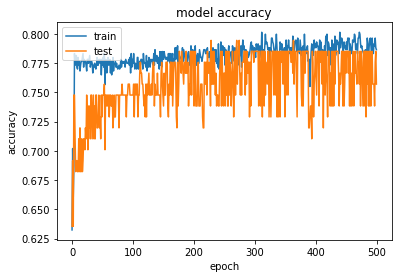

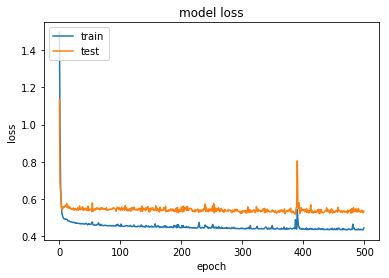

In [86]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [87]:
y_test_nn_pred = model.predict(dataProc.X_test.reindex(columns=sortedCols))
y_test_nn_pred = np.where(y_test_nn_pred > 0.5, 1, 0)
print('Stacking %.3f ' % accuracy_score(dataProc.y_test, y_test_nn_pred))

Stacking 0.775 


## Random forest model

In [ ]:
preProc = ColumnTransformer([
    #('StdScaler', StandardScaler(), numCols),
    #('OneHot', OneHotEncoder(handle_unknown='ignore'), catCols)
])
rf = RandomForestClassifier(random_state = randomSeed)
rfpipeline = Pipeline([#('preProcessing', preProc),
                       #('ReduceDim', SelectKBest(f_classif)),
                       ('rf', rf)])
params = {
   # 'ReduceDim__k' : range(5, 11),
    'rf__n_estimators' : range(3, 20),
    'rf__max_depth' : range(1, 5),
    'rf__max_features' : ['sqrt', 'log2', None]
}
rfcv = RandomizedSearchCV(rfpipeline, n_iter= 1000, scoring = 'accuracy', 
                          param_distributions=params, verbose=1, cv = 10, n_jobs = numCores, random_state=randomSeed)

## XGB model

In [ ]:
param_grid = {
    'xgb__max_depth' : [3, 4, 5, 6],
    'xgb__learning_rate' : [0.05, 0.1, 0.2],
    'xgb__n_estimators' : range(5, 21),
    'xgb__subsample' : [0.8, 0.9, 0.95],
    #'xgb__colsample_bytree' : [0.8, 0.9, 0.95],
    'xgb__reg_alpha' : [0.05, 0.1, 0.2, 0.4],
    'xgb__reg_lambda' : [0.05, 0.1, 0.2, 0.4],
    'xgb__gamma' : [0.0001, 0.001, 0.01, 0.1]
}

xgb = xgboost.XGBClassifier(seed=randomSeed)
xgbpipeline = Pipeline([#('preProcessing', preProc),
                        ('xgb', xgb)])
xgbcv = RandomizedSearchCV(xgbpipeline, n_iter = 500, cv=10, param_distributions =param_grid,
                        scoring='accuracy', verbose = 1, n_jobs = numCores, random_state=randomSeed)

## AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
param_grid = {
    'ada__learning_rate' : [0.05, 0.1, 0.2],
    'ada__n_estimators' : range(5, 21)
}
ada = AdaBoostClassifier(n_estimators=100, random_state=randomSeed)
adapipeline = Pipeline([('ada', ada)])
adacv = RandomizedSearchCV(adapipeline, n_iter = 500, cv=10, param_distributions =param_grid,
                           scoring='accuracy', verbose = 1, n_jobs = numCores, random_state=randomSeed)

## Logistic regression

In [ ]:
from sklearn import linear_model
param_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(0, 4, 10),
    'solver' : ['liblinear', 'saga']
}
C = np.logspace(0, 4, 10)
logistic = linear_model.LogisticRegression()
logisticCV = GridSearchCV(logistic, param_grid, cv=20, verbose=1)

## Model stacking

In [ ]:
from mlens.ensemble import BlendEnsemble
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

estimators = [rfcv, adacv, xgbcv]
ensemble = BlendEnsemble()
ensemble.add(estimators, proba=True)   # Specify 'proba' here
ensemble.add_meta(logisticCV)

In [ ]:
ensemble.fit(dataProc.X_train.reindex(columns=sortedCols), dataProc.y_train)

In [ ]:
y_test_stacking_pred = ensemble.predict(dataProc.X_test.reindex(columns=sortedCols))
print('Stacking %.3f ' % accuracy_score(dataProc.y_test, y_test_stacking_pred))

In [ ]:
submitDataProc.AllData[target] = ensemble.predict(submitDataProc.X.reindex(columns=sortedCols)).astype('int')
submitDataProc.AllData[['PassengerId', 'Survived']].to_csv('submit.txt', index=False)